In [1]:
import numpy as np
import os, sys
import yaml
import astropy.io.ascii as ascii
%pylab inline
from astropy.io import fits
from astropy.table import Table,join
import astropy as ap
from multiprocessing import Pool,Value
from functools import partial
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy import ndimage
from matplotlib.patches import Ellipse, Circle
from sklearn import linear_model

Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [28]:
def display_voronoi(x, y, counts, pixelsize, z_2d,ax=False):

    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    nx = int(np.round((xmax - xmin)/pixelsize) + 1)
    ny = int(np.round((ymax - ymin)/pixelsize) + 1)
    img = np.full((nx, ny), np.nan)  # use nan for missing data
    j = np.round((x - xmin)/pixelsize).astype(int)
    k = np.round((y - ymin)/pixelsize).astype(int)
#     _,_,bin_signal,noise_signal = voronoi_binned_data(x,y,flux,err,binNum)
#     img[j, k] = array([(bin_signal/noise_signal)[binNum[i]==np.unique(binNum)][0] for i in range(len(binNum))])
    img[j, k] = array([(z_2d)[binNum[i]==np.unique(binNum)][0] for i in range(len(binNum))])

    if ax != False:
        im = ax.imshow(np.rot90(img), interpolation='nearest', cmap='jet',
               extent=[xmin - pixelsize/2, xmax + pixelsize/2,
                       ymin - pixelsize/2, ymax + pixelsize/2])
        colorbar(im,ax=ax)
    else:
        plt.imshow(np.rot90(img), interpolation='nearest', cmap='jet',
                   extent=[xmin - pixelsize/2, xmax + pixelsize/2,
                           ymin - pixelsize/2, ymax + pixelsize/2])
        plt.colorbar()

In [3]:
# source_id = np.loadtxt('source_id.txt',dtype=str)

source_id = np.array(['00262', '00313', '00613', '00769', '01394',
       '01435', '01464', '01467', '01890', '01998',
       '02327', '02330', '03061', '03155',
       '03276', '03331', '03495', '03516'])


z_table = []
z_2d = []
z_2d_up1 = []
z_2d_low1 = []
for id_name in source_id:
    z = Table.read('output_10pix_sm/ELD_oh12_2d_id%s.txt'%id_name,format='ascii.commented_header')
    z_table.append(z)
    z_2d.append(z['me'].copy().reshape(20,20))
    z_2d_up1.append(z['me_up1sig'].copy().reshape(20,20))
    z_2d_low1.append(z['me_low1sig'].copy().reshape(20,20))

In [4]:
ra = np.array([])
dec = np.array([])
for i in source_id:
    info = Table.read('../grismspec_boss1244_210627/boss1244_DR210308_%s.row.fits'%i,hdu=1)
    ra = np.append(ra,asarray(info['ra']))
    dec = np.append(dec,asarray(info['dec']))

In [5]:
w = 10

j1244_cut = fits.open('../Photometry/j1244_cut.fits')
j1244_cut_img = j1244_cut[0].data
j1244_cut.close()

h1244_cut = fits.open('../Photometry/h1244_cut.fits')
h1244_cut_img = h1244_cut[0].data
h1244_cut.close()

w_j_cut = WCS(j1244_cut[0].header)
j1244_cut.close()

c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree)

j_x = w_j_cut.world_to_pixel(c)[0]
j_y = w_j_cut.world_to_pixel(c)[1]

h1244_wht = fits.open('../Photometry/h1244_wht_cut.fits')
h1244_wht_img = h1244_wht[0].data

seg_all = fits.open('/home/zihao/win/study/astrophysics/sextractor-2.25.0/tests/h1244/h1244.seg.fits')
seg_all = seg_all[0].data

s_pix = w
h_stamp = []
h_wht_stamp = []
seg_stamp = []
for i in range(len(source_id)):

    j_cutx = round(j_x[i])
    j_cuty = round(j_y[i])
#     j_stamp.append(j1244_cut_img[j_cuty-s_pix:j_cuty+s_pix,j_cutx-s_pix:j_cutx+s_pix])
    h_stamp.append(h1244_cut_img[j_cuty-s_pix:j_cuty+s_pix,j_cutx-s_pix:j_cutx+s_pix])
    h_wht_stamp.append(h1244_wht_img[j_cuty-s_pix:j_cuty+s_pix,j_cutx-s_pix:j_cutx+s_pix])
    seg_stamp.append(seg_all[j_cuty-s_pix:j_cuty+s_pix,j_cutx-s_pix:j_cutx+s_pix])

In [37]:
fitnumber = ['0'*(2-len(str(i)))+str(i) for i in np.arange(len(z_2d))+1]

galfit = []
for i,n in enumerate(id_table):
    file = open("galfit/galfit_output_10pix/galfit_%s.txt"%n, "r")
    name = file.readlines()
    x = float(name[40][4:11])
    y = float(name[40][13:20])
    R_e = float(name[42][4:11])
    ab = float(name[47][4:11])
    angle = float(name[48][4:11])

    a = R_e
    b = R_e*ab
    galfit.append(np.array([x,y,a,b,angle]))

In [6]:
# selected sources with voronoi bins > 13
id_table = np.array(['00262', '00313', '00613', '00769', '01394',
       '01435', '01464', '01467', '01890', '01998',
       '02327', '02330', '03061', '03155',
       '03276', '03331', '03495', '03516'])

In [7]:
sids = array(['00010', '00061', '00119', '00211', '00262', '00284', '00313',
       '00381', '00382', '00467', '00478', '00508', '00613', '00769',
       '00897', '00936', '00996', '01056', '01070', '01071', '01089',
       '01112', '01161', '01165', '01267', '01269', '01335', '01351',
       '01394', '01397', '01417', '01435', '01464', '01467', '01573',
       '01608', '01704', '01734', '01793', '01808', '01855', '01878',
       '01890', '01902', '01998', '01999', '02090', '02258', '02327',
       '02330', '02388', '02474', '02484', '02512', '02588', '02611',
       '02771', '02835', '02992', '03061', '03155', '03196', '03261',
       '03276', '03331', '03340', '03385', '03480', '03495', '03496',
       '03516'], dtype='<U5')

idx_71_to_select = []
for id_name in id_table:
    idx_71_to_select.append(where(array(sids)==id_name)[0][0])

In [8]:
import statsmodels.api as sm

In [17]:
z_table_vor = []
z_2d_vor = []
z_2d_up1_vor = []
z_2d_low1_vor = []
for id_name in id_table:

    z = np.load('output_vor_SNR_2.5_sm_noweight/ELD_oh12_2d_id%s.npy'%id_name,allow_pickle=True).item()
    z_table_vor.append(z)
    z_2d_vor.append(np.array(z['me']).copy())
    z_2d_up1_vor.append(np.array(z['me_up1sig']).copy())
    z_2d_low1_vor.append(np.array(z['me_low1sig']).copy())

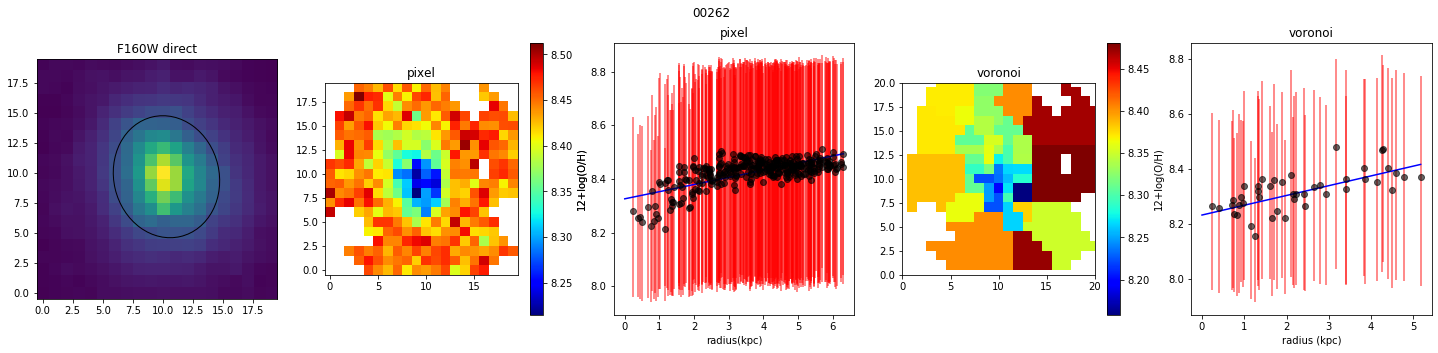

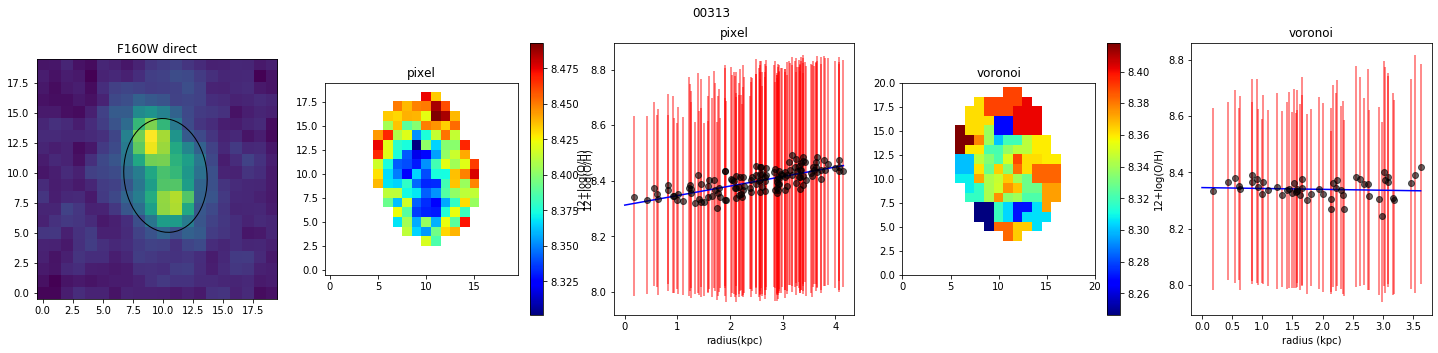

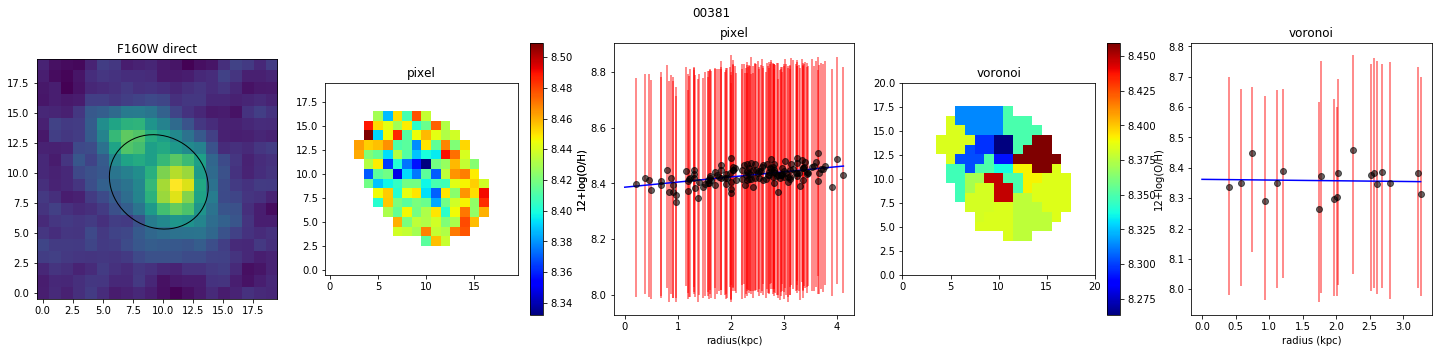

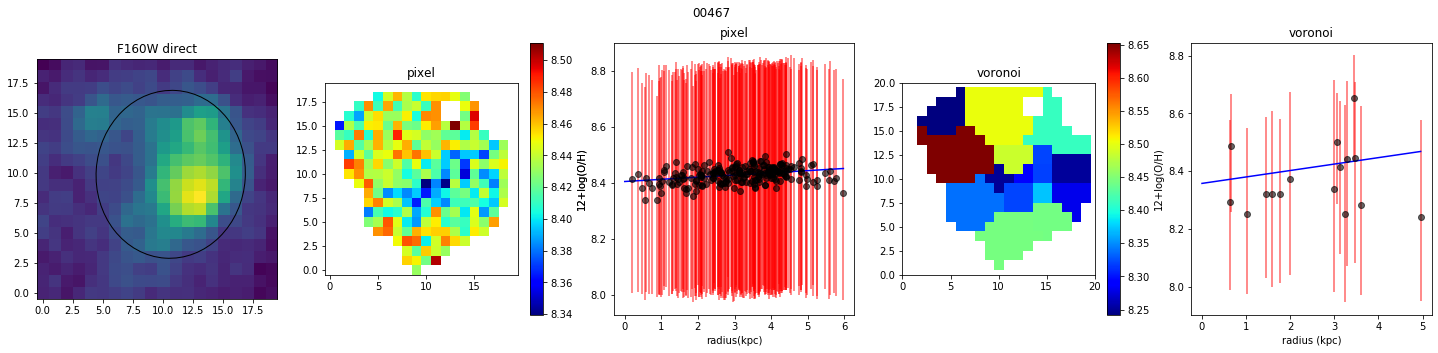

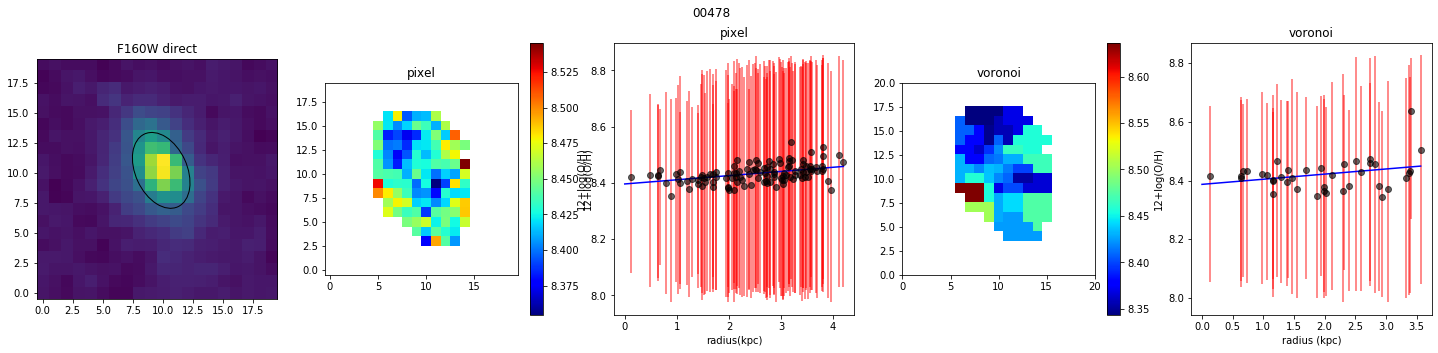

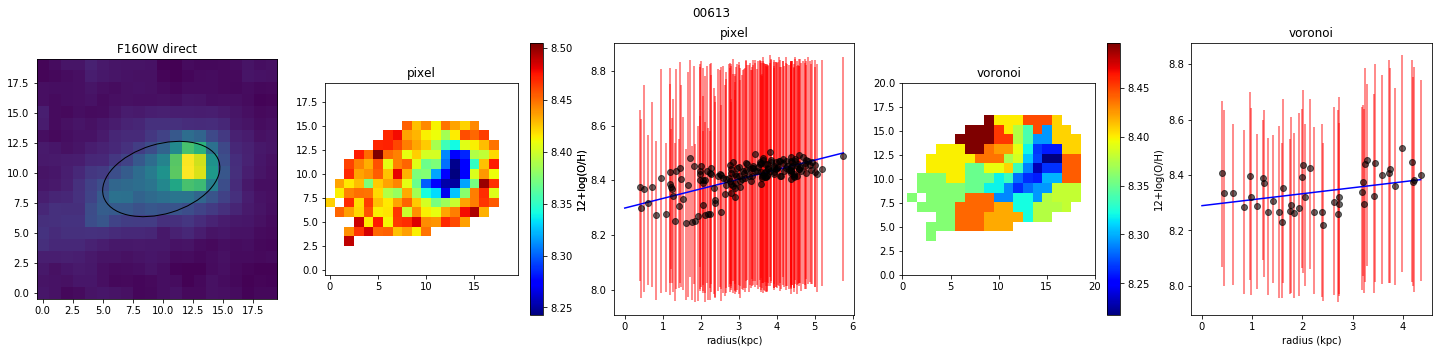

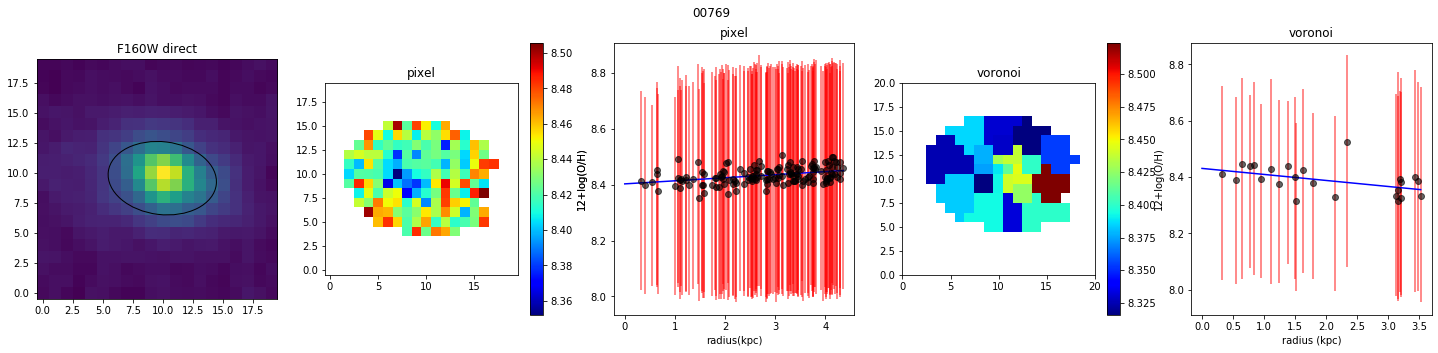

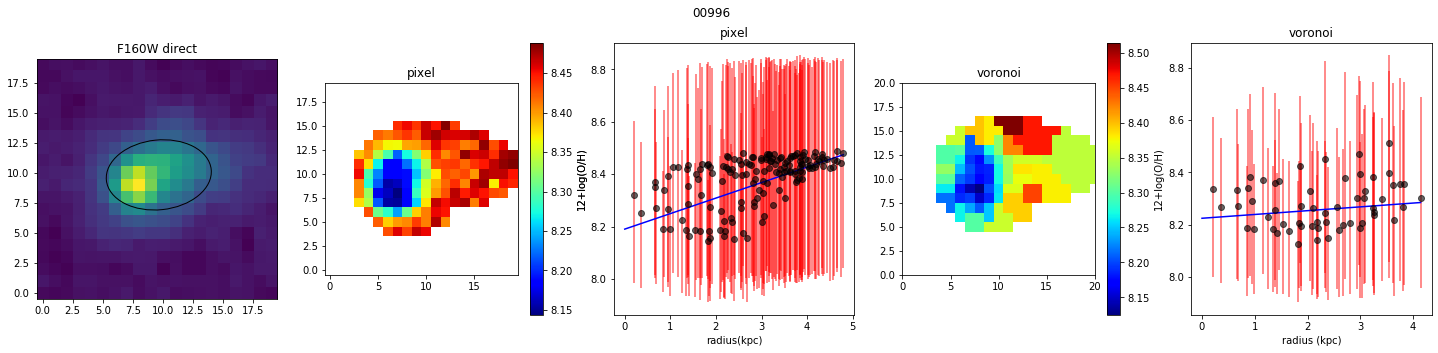

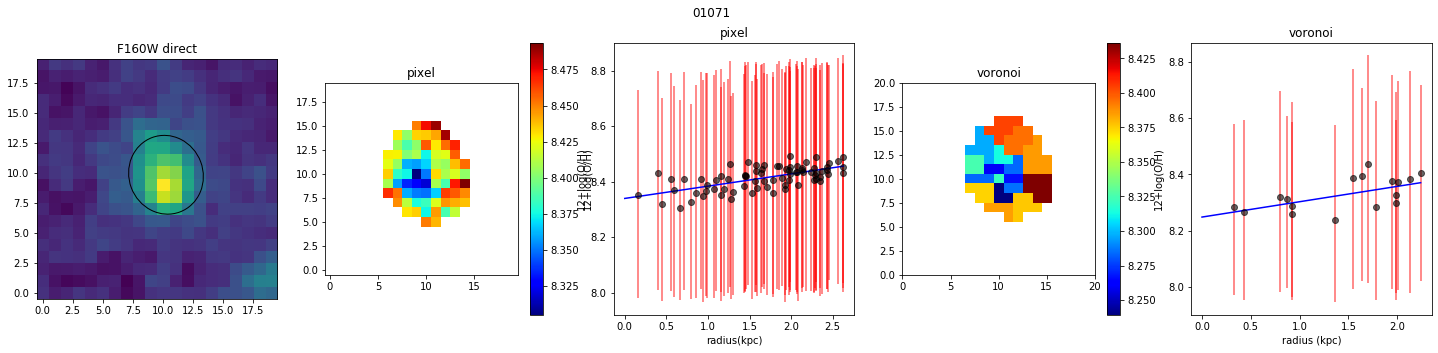

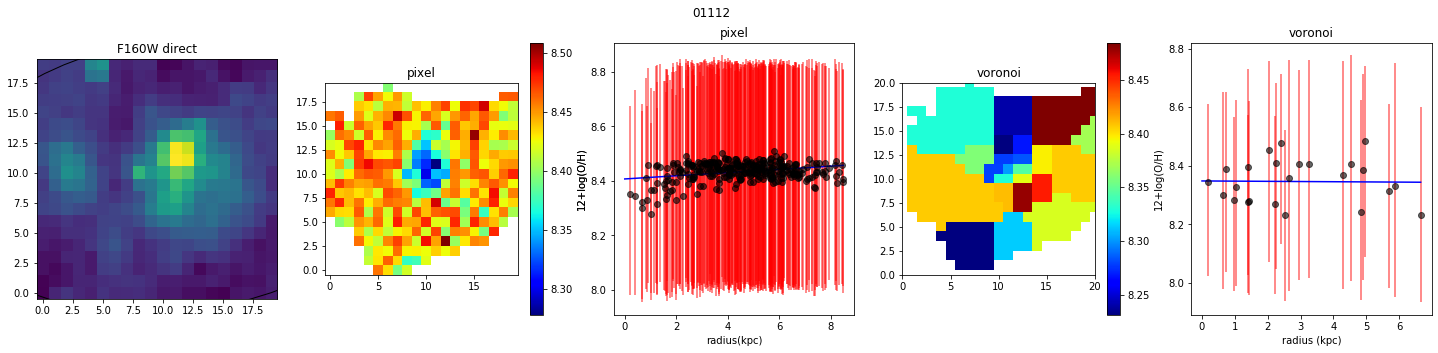

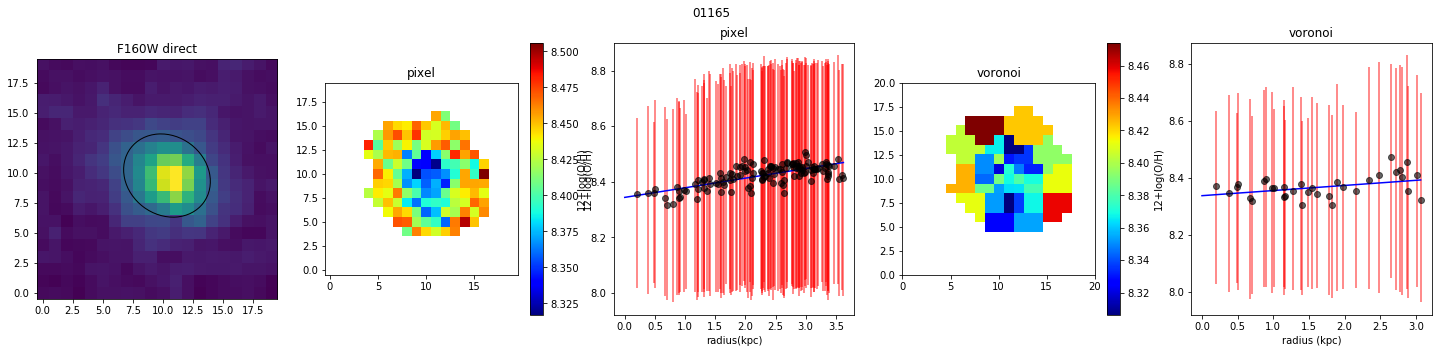

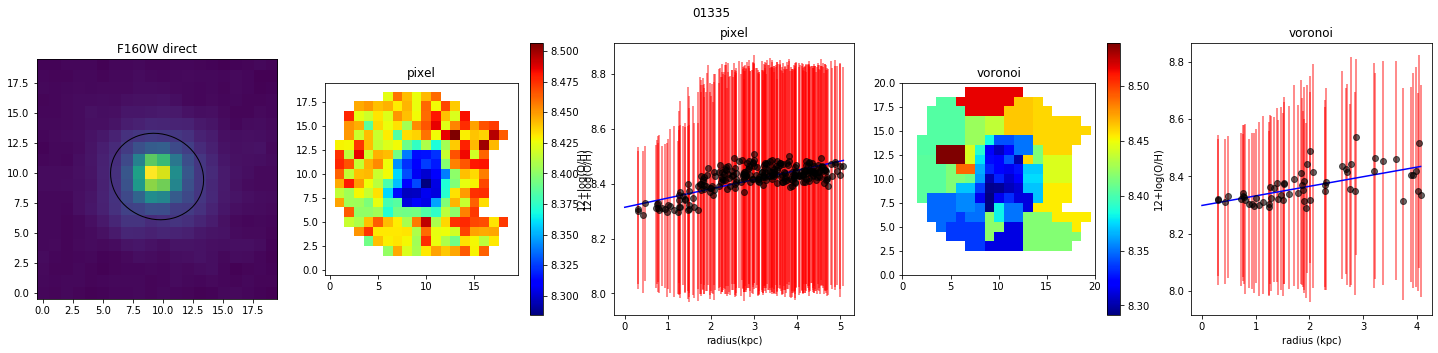

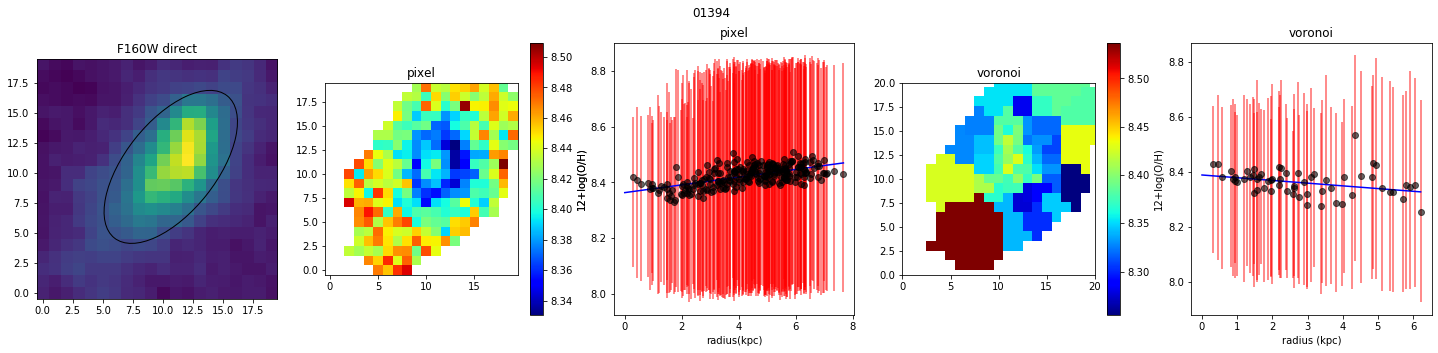

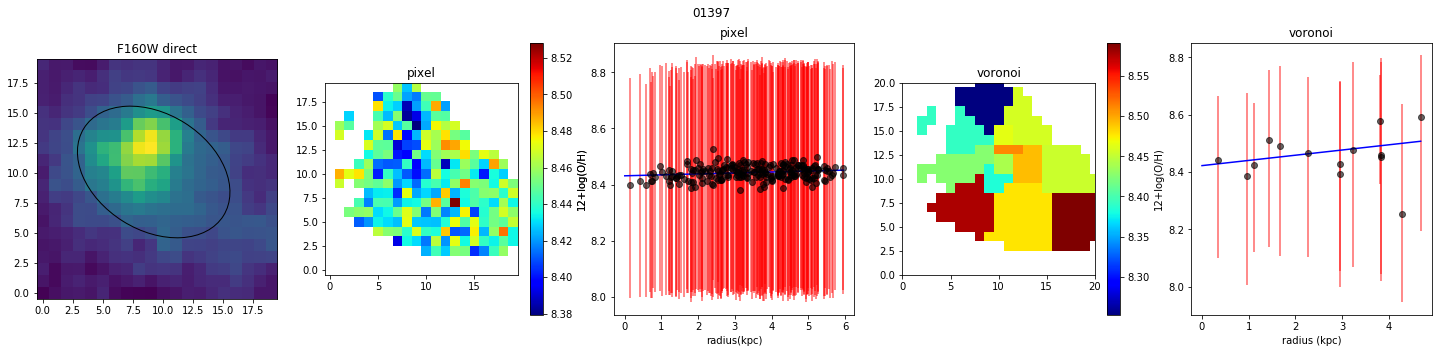

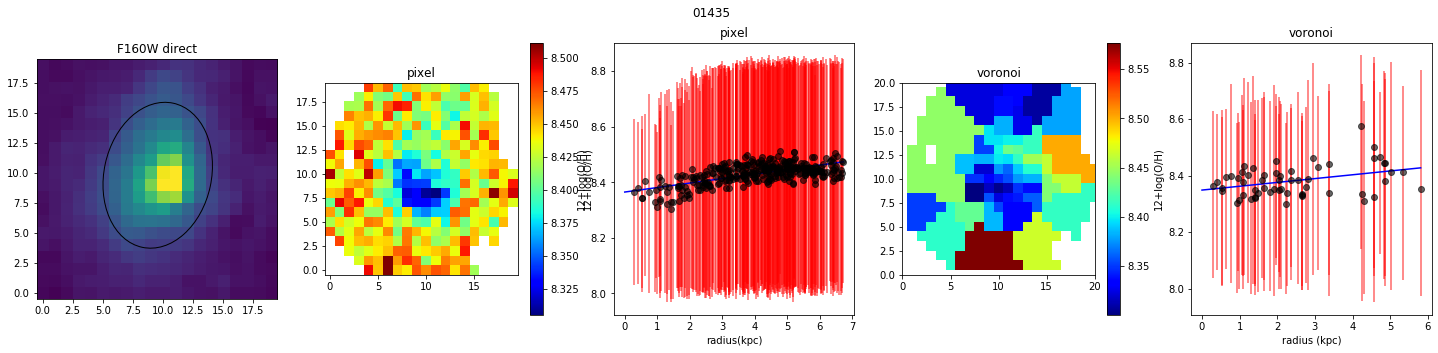

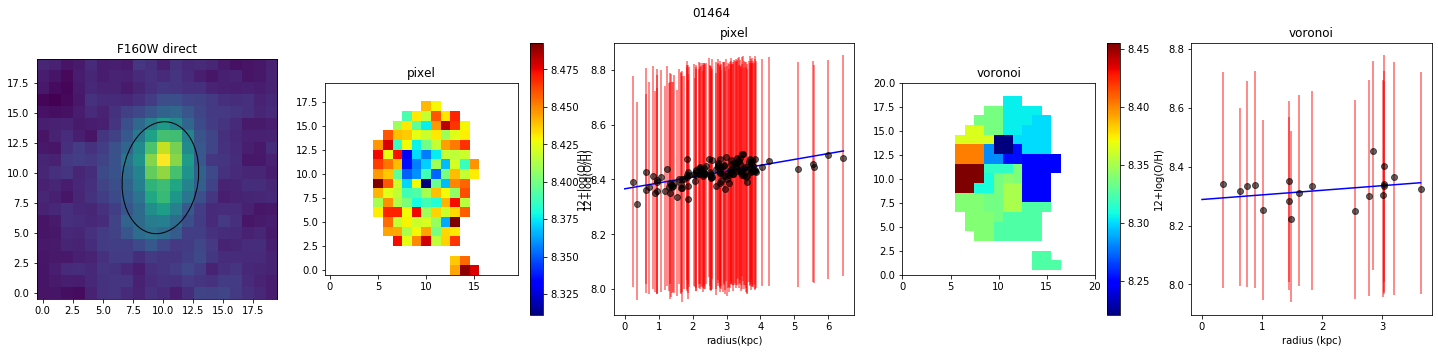

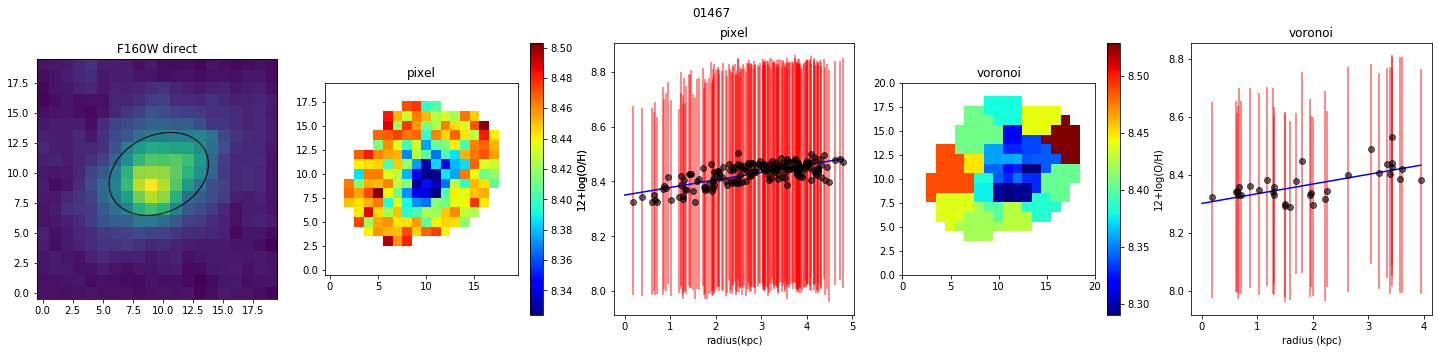

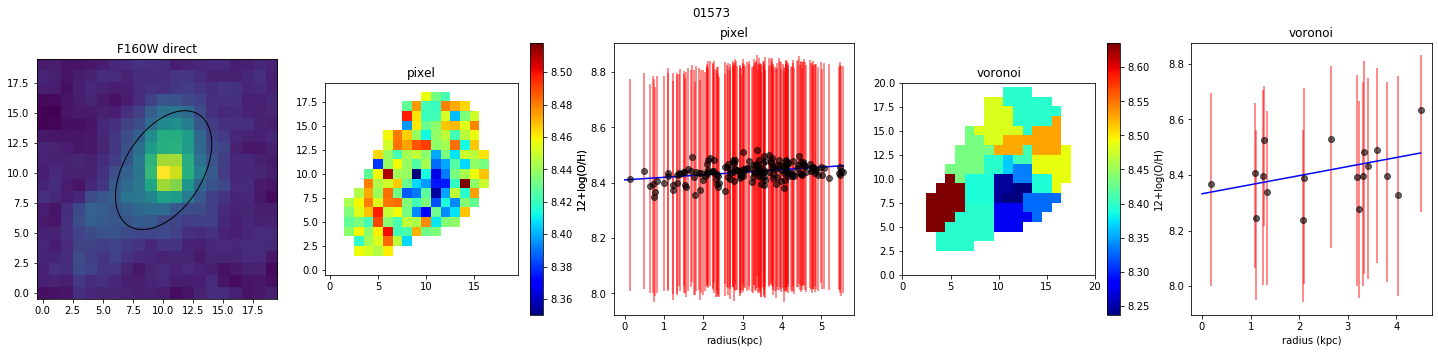

In [38]:
EL = ['flux_OIII','flux_Hb','flux_Hg','flux_OII']
slope_pix = []
slope_pix_err = []

slope_vor = []
slope_vor_err = []
for i,id_name in enumerate(id_table):
    info = Table.read('../grismspec_boss1244_210627/boss1244_DR210308_%s.row.fits'%id_name,hdu=1)

    redshift = info['redshift']
    z_crop = z_2d[i]
    z_low1_crop = z_2d_low1[i]
    z_up1_crop = z_2d_up1[i]
    
    fig,ax = plt.subplots(1,5,figsize=(25,5))
    ax[0].imshow(h_stamp[i],origin='lower')
    ax[0].set_title('F160W direct')
    
    im1 = ax[1].imshow(z_crop,cmap='jet',origin='lower')
    ax[1].set_title('pixel')
    ax[2].set_title('pixel')
    ax[3].set_title('voronoi')
    ax[4].set_title('voronoi')

    plt.colorbar(im1,ax=ax[1],label='12+log(O/H)')
    
    crop_idx = np.where(np.isnan(z_crop.flatten()))
    z_crop = np.delete(z_crop,crop_idx)
    z_low1_crop = np.delete(z_low1_crop,crop_idx)
    z_up1_crop = np.delete(z_up1_crop,crop_idx)
    x,y = np.meshgrid(linspace(1,20,20),linspace(1,20,20))
    x = np.delete(x.flatten(),crop_idx)
    y = np.delete(y.flatten(),crop_idx)
    x -= galfit[i][0]
    y -= galfit[i][1]
    coord = np.array([x.flatten(),y.flatten()])
    angle = -(90+galfit[i][4])*2*np.pi/360

    ab = galfit[i][3]/galfit[i][2]
    trans1 = np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]])
    trans2 = np.array([[1,0],[0,1/ab]])
    mat_trans = trans2@trans1
    
    x,y=mat_trans@coord
    d = (x**2+y**2)**0.5
    d = cosmo.angular_diameter_distance(redshift).to('kpc').value*d*0.06*2*np.pi/360/3600

    ell1 = Ellipse(xy = (galfit[i][:2]-1), width = 2*galfit[i][2], height = 2*galfit[i][3], angle = 90+galfit[i][4], ec= 'k',fill=False, alpha=1.0)
    ax[0].add_artist(ell1)
    
    ax[2].errorbar(d,z_crop,yerr=(z_crop-z_low1_crop,z_up1_crop-z_crop),
                    fmt='o',ecolor='r',color='k',elinewidth=0,capsize=0,alpha=0.6)
    x = d
    y = z_crop.flatten()
    weight = (2/(z_up1_crop.flatten()-z_low1_crop.flatten()))**2
    x = sm.add_constant(x)
    model = sm.WLS(y,x,weight).fit() 
    b,k = model.params
    ax[2].plot(array([0,d.max()]),array([b,b+k*d.max()]),c='blue')
    ax[2].set_xlabel('radius(kpc)')
    ax[2].set_ylabel('12+log(O/H)')
    
    slope_pix.append(k)
    slope_pix_err.append(model.bse[1])
    
    
    # voronoi results
    binNum, x, y = z_table_vor[i]['binNum'].copy(),z_table_vor[i]['xNode'].copy(),z_table_vor[i]['yNode'].copy()
    x_display = z_table_vor[i]['x_display']
    y_display = z_table_vor[i]['y_display']

    x -= galfit[i][0]
    y -= galfit[i][1]
    coord = np.array([x.flatten(),y.flatten()])

#     angle = -(90+galfit[i][4])*2*np.pi/360
#     ab = galfit[i][3]/galfit[i][2]
#     trans1 = np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]])
#     trans2 = np.array([[1,0],[0,1/ab]])
#     mat_trans = trans2@trans1
    
    x,y=mat_trans@coord
    d = (x**2+y**2)**0.5
        
    d = cosmo.angular_diameter_distance(z).to('kpc').value*d*0.06*2*np.pi/360/3600
    ax[4].errorbar(d,z_2d_vor[i],yerr=(z_2d_vor[i]-z_2d_low1_vor[i],z_2d_up1_vor[i]-z_2d_vor[i]),
                   fmt='o',ecolor='r',color='k',elinewidth=0,capsize=0,alpha=0.6)

    # Fit linear regressing to metallicity versus radius
    x = d
    y = z_2d_vor[i].flatten()
    weight = (2/(z_2d_up1_vor[i]-z_2d_low1_vor[i]))**2
    
    x = x[~isnan(weight)]
    y = y[~isnan(weight)]
    weight = weight[~isnan(weight)]
    x = sm.add_constant(x)
    model = sm.WLS(y,x,weight).fit()
    b,k = model.params
    ax[4].plot(array([0,d.max()]),array([b,b+k*d.max()]),c='blue')

    ax[4].set_xlabel('radius (kpc)')
    ax[4].set_ylabel('12+log(O/H)')
    plt.suptitle(source_id[i])
    display_voronoi(x_display,y_display,binNum,1,z_2d_vor[i],ax[3])
    ax[3].set_xlim(0,20)
    ax[3].set_ylim(0,20)    
    
    slope_vor.append(k)
    slope_vor_err.append(model.bse[1])
    plt.show()

    
slope_vor = array(slope_vor)
slope_vor_err = np.array(slope_vor_err)
slope_pix = array(slope_pix)
slope_pix_err = np.array(slope_pix_err)

In [39]:
sed_paras = Table.read('sedcat_merge_210623.fits')
sed_paras.remove_column('#ID')
sed_paras.add_column(sids,name='ID',index=0)

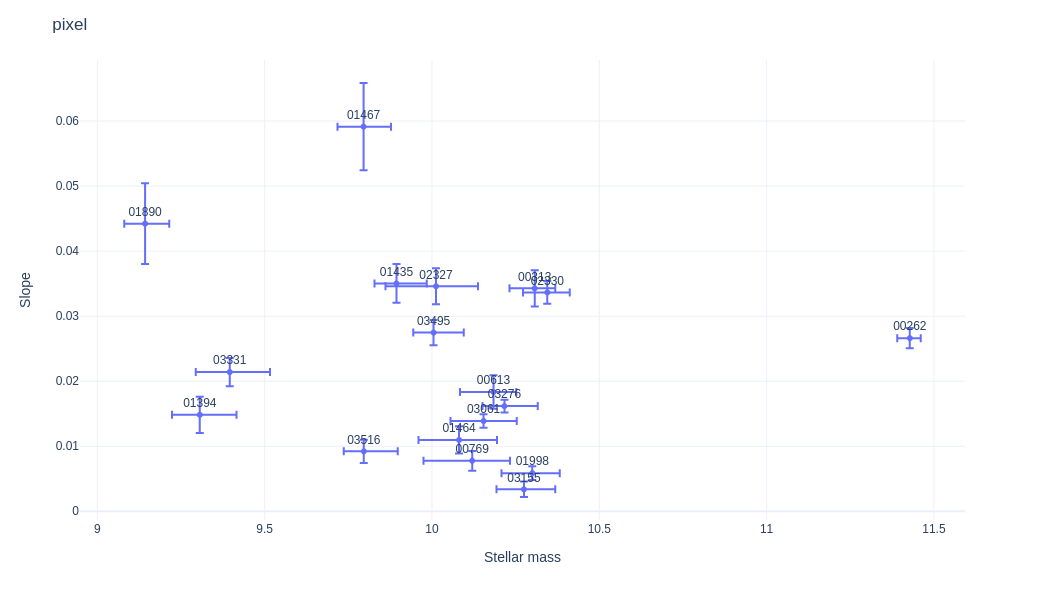

In [54]:
import plotly.express as px

fig = px.scatter(x=np.asarray(sed_paras[idx_71_to_select]['stellar_mass_50']).astype(float64),y=slope_pix,
                 error_x_minus=sed_paras[idx_71_to_select]['stellar_mass_50']-sed_paras[idx_71_to_select]['stellar_mass_16'],
                 error_x=sed_paras[idx_71_to_select]['stellar_mass_84']-sed_paras[idx_71_to_select]['stellar_mass_50'],
                 error_y=slope_pix_err,
                 text=id_table,template='plotly_white',labels={'x':'Stellar mass','y':r'Slope'})


fig.update_traces(textposition='top center')

fig.update_layout(
    height=600,
    width=600,
    title_text='pixel'
)

fig.show()


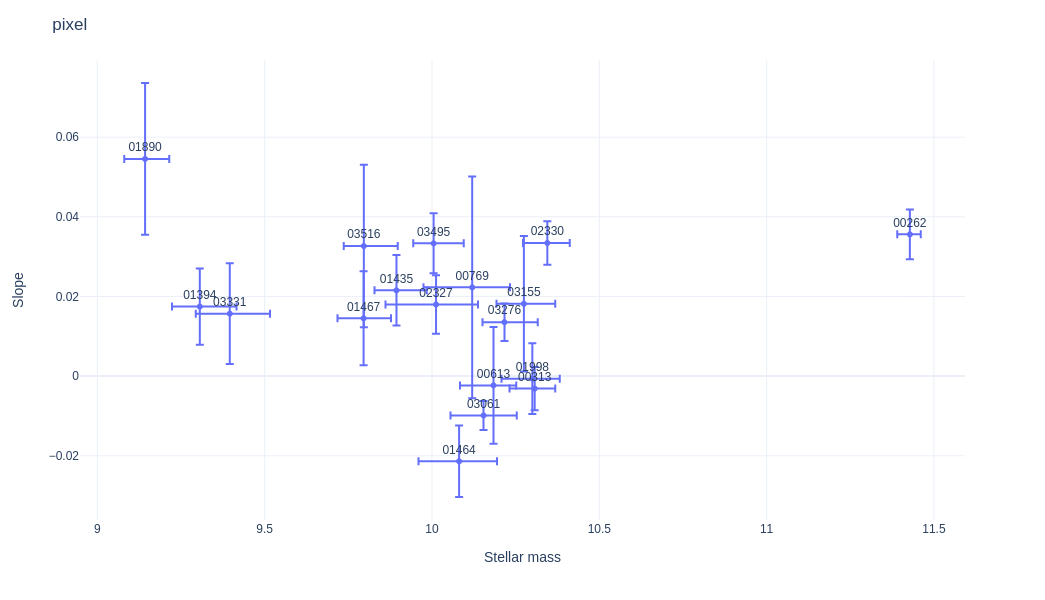

In [57]:
import plotly.express as px

fig = px.scatter(x=np.asarray(sed_paras[idx_71_to_select]['stellar_mass_50']).astype(float64),y=slope_vor,
                 error_x_minus=sed_paras[idx_71_to_select]['stellar_mass_50']-sed_paras[idx_71_to_select]['stellar_mass_16'],
                 error_x=sed_paras[idx_71_to_select]['stellar_mass_84']-sed_paras[idx_71_to_select]['stellar_mass_50'],
                 error_y=slope_vor_err,
                 text=id_table,template='plotly_white',labels={'x':'Stellar mass','y':r'Slope'})


fig.update_traces(textposition='top center')

fig.update_layout(
    height=600,
    width=600,
    title_text='pixel'
)

fig.show()


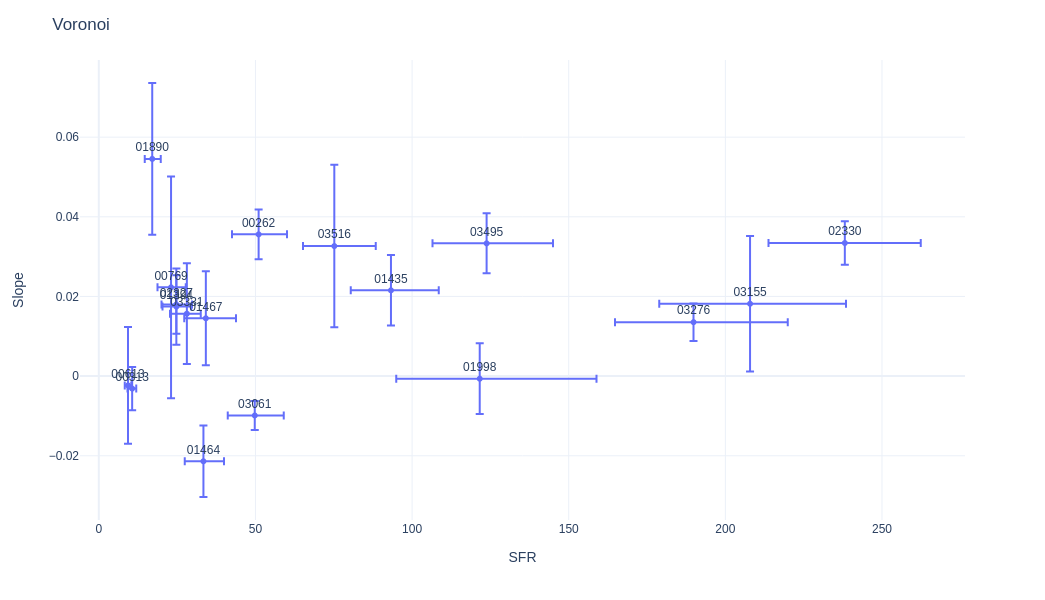

In [58]:
fig = px.scatter(x=np.asarray(sed_paras[idx_71_to_select]['sfr_50']).astype(float64),y=slope_vor,
                 error_x_minus=sed_paras[idx_71_to_select]['sfr_50']-sed_paras[idx_71_to_select]['sfr_16'],
                 error_x=sed_paras[idx_71_to_select]['sfr_84']-sed_paras[idx_71_to_select]['sfr_50'],
                 error_y=slope_vor_err,
                 text=id_table,template='plotly_white',labels={'x':'SFR','y':'Slope'})


fig.update_traces(textposition='top center')

fig.update_layout(
    height=600,
    width=600,
    title_text='Voronoi'
)

fig.show()

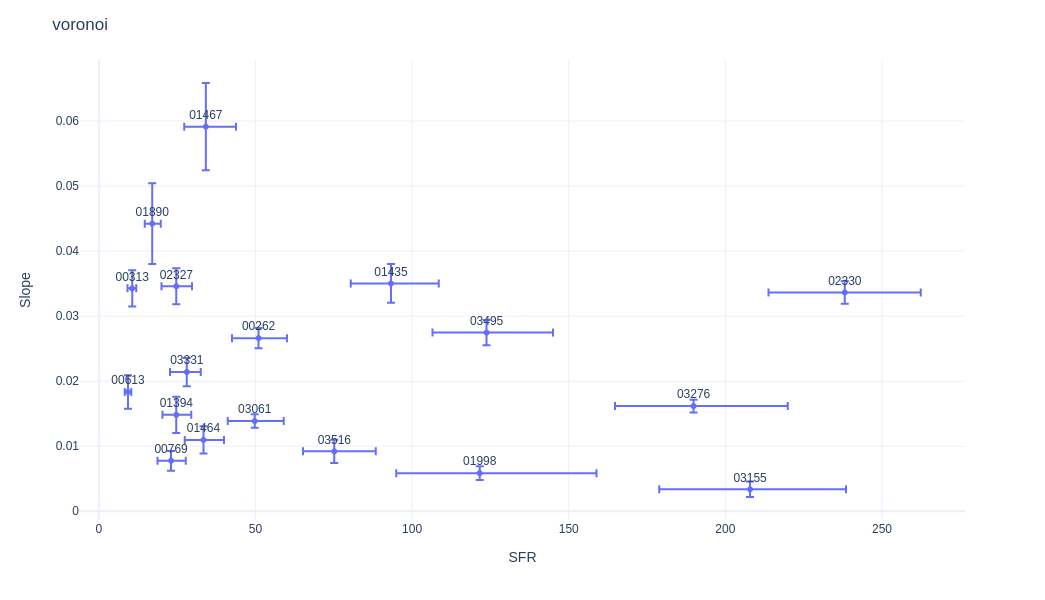

In [59]:
fig = px.scatter(x=np.asarray(sed_paras[idx_71_to_select]['sfr_50']).astype(float64),y=slope_pix,
                 error_x_minus=sed_paras[idx_71_to_select]['sfr_50']-sed_paras[idx_71_to_select]['sfr_16'],
                 error_x=sed_paras[idx_71_to_select]['sfr_84']-sed_paras[idx_71_to_select]['sfr_50'],
                 error_y=slope_pix_err,
                 text=id_table,template='plotly_white',labels={'x':'SFR','y':'Slope'})


fig.update_traces(textposition='top center')

fig.update_layout(
    height=600,
    width=600,
    title_text='voronoi'
)

fig.show()